## Setup

In [36]:
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

## Exploration using BQ
`06_dataproc.ipynb`では、dataproc x sparkを使う

### 出発が10分以上遅れたフライトの到着遅延時間の調査

In [37]:
sql = """
SELECT DEP_DELAY, ARR_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = bq.Query(sql).execute().result().to_dataframe()

グラフ

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


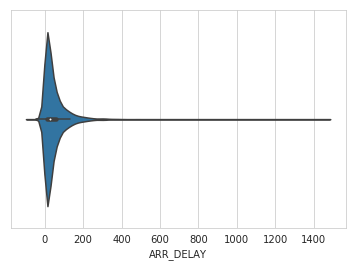

In [38]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

統計値

In [39]:
df.describe()

,DEP_DELAY,ARR_DELAY
count,14063.000000,13977.000000
mean,51.702979,46.805752
std,65.732746,67.675671
min,10.000000,-78.000000
25%,17.000000,11.000000
50%,30.000000,27.000000
75%,61.000000,59.000000
max,1429.000000,1467.000000


### 出発が10分以上遅れたフライトとそうでないフライトの到着遅延時間を比較

In [40]:
sql = """
SELECT DEP_DELAY, ARR_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.01
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [41]:
df['ontime'] = df['DEP_DELAY'] < 10

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-50, 200)

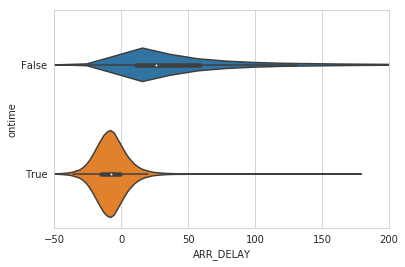

In [42]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200)

(-50, 50)

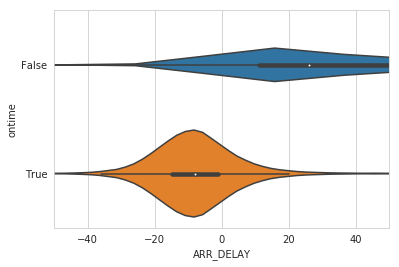

In [43]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 50)

### 出発遅延時間の外れ値の除外

出発遅延時間ごとに到着遅延時間の平均と標準偏差、該当するフライト数を計算
- フライト数が370便以下のデータは3シグマの法則を満たさない(=標準偏差のグラフを描くのに十分な母数でない)として排除
-  -> グラフの広がり(標準偏差)が一定になる

In [55]:
depdelayquery = """
SELECT 
  DEP_DELAY,
  arrival_delay,
  stddev_arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) as arrival_delay,
    STDDEV(ARR_DELAY) as stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY
)
WHERE numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay = bq.Query(depdelayquery).execute().result().to_dataframe()
depdelay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-24.005747,11.095207,522
1,-22.0,-23.258693,12.300774,719
2,-21.0,-22.606495,12.094192,1047
3,-20.0,-21.538365,12.075209,1590
4,-19.0,-20.591874,12.133052,2215


#### グラフがきれいになった

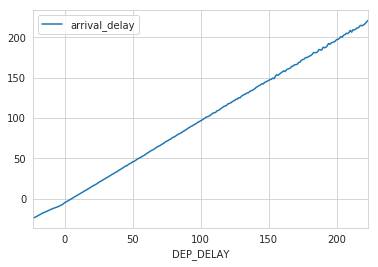

In [56]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay')

#### 標準偏差も安定した

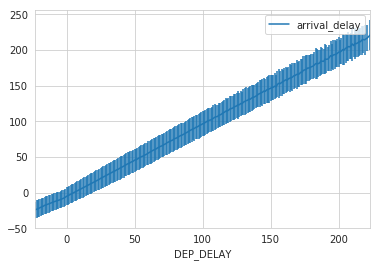

In [57]:
ax = depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay', yerr='stddev_arrival_delay')

## 「M分出発時間が遅れたら30%の確率で15分以上到着時間が遅れる」のMを求める

### 統計的観点で求める

#### 求めたい値
「平均:a, 標準偏差:sの場合、到着遅延時間がX以上になる確率は30%」となる場合のX  
-> 30%の確率で到着遅延時間がXを超えるよ  
なぜZ_30=0.52?

**標準偏差的観点での求める**
1. Xを[標準化](https://bellcurve.jp/statistics/glossary/1222.html)
  - 標準化: 平均が0、分散が1となるようにデータを変換すること
  - (X - m)/s  = z
  - z  -> 標準化したこの値を求めればX求まる
2. 「平均値:0, 標準偏差:1の場合、値がz以上になる確率は30%」となる場合のzを[標準正規分布表](https://bellcurve.jp/statistics/course/7805.html)から求める
  - z = 0.52
3. zを逆標準化
  - X = z * s + m

Text(0, 0.5, '> 30% likelihood of this ArrivalDelay(minutes)')

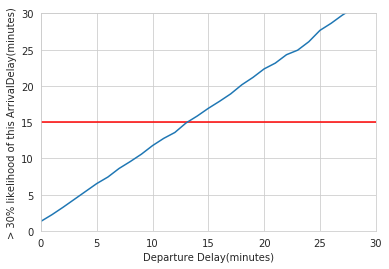

In [80]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (Z_30 * depdelay['stddev_arrival_delay']) + depdelay['arrival_delay']
plt.axhline(y=15, color='r')
ax = plt.axes()

depdelay.plot(kind='line', x='DEP_DELAY', y='arr_delay_30', ax=ax, ylim=(0,30), xlim=(0,30),legend=False)
ax.set_xlabel('Departure Delay(minutes)')
ax.set_ylabel('> 30% likelihood of this ArrivalDelay(minutes)')

 -> 出発遅延時間が13分以上であれば、到着遅延時間が15分以上となる確率が30%以上ある

### パーセンタイル的観点での求める

近似分位法を行って、各出発遅延時間に対する到着遅延時間の、(最小値を0, 最大値を100とした場合の)70%のデータを割り出すデータ数が同じになるように間隔をきる
- **APPROX_QUANTILES**  -> **今回はこっちを使用**
  - BigQueryで近似分位法を行う関数
- approxQuantile
  - sparkで近似分位法を行う関数

In [88]:
depdelayquery2 = """
SELECT
  DEP_DELAY,
  APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay2 = bq.Query(depdelayquery2).execute().result().to_dataframe()
depdelay2[:5]

,DEP_DELAY,arrival_delay,numflights
0,-23.0,-20.0,522
1,-22.0,-19.0,719
2,-21.0,-18.0,1047
3,-20.0,-17.0,1590
4,-19.0,-16.0,2215


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, '> 30% likelihood of this ArrivalDelay(minutes)')

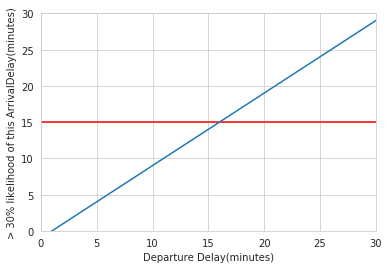

In [89]:
plt.axhline(y=15, color='r')
ax = plt.axes()

depdelay2.plot(kind='line', x='DEP_DELAY', y='arrival_delay', ax=ax, ylim=(0,30), xlim=(0,30),legend=False)
ax.set_xlabel('Departure Delay(minutes)')
ax.set_ylabel('> 30% likelihood of this ArrivalDelay(minutes)')

 -> 出発遅延時間が16分以上であれば、到着遅延時間が15分以上となる確率が30%以上ある

### データセットをtrain, testに分ける

In [111]:
depdelayquery_train = """
SELECT *
FROM (
    SELECT
      DEP_DELAY,
      APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
      COUNT(ARR_DELAY) AS numflights
    FROM
      `flights.tzcorr` f
    JOIN
      `flights.trainday` t
    ON
      f.FL_DATE = t.FL_DATE
    WHERE
      t.is_train_day = 'True'
    GROUP BY
      DEP_DELAY
)
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

depdelayquery_test = """
SELECT *
FROM (
    SELECT
      DEP_DELAY,
      APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
      COUNT(ARR_DELAY) AS numflights
    FROM
      `flights.tzcorr` f
    JOIN
      `flights.trainday` t
    ON
      f.FL_DATE = t.FL_DATE
    WHERE
      t.is_train_day = 'False'
    GROUP BY
      DEP_DELAY
)
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

depdelay_train = bq.Query(depdelayquery_train).execute().result().to_dataframe()
depdelay_test = bq.Query(depdelayquery_test).execute().result().to_dataframe()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, '> 30% likelihood of this ArrivalDelay(minutes)')

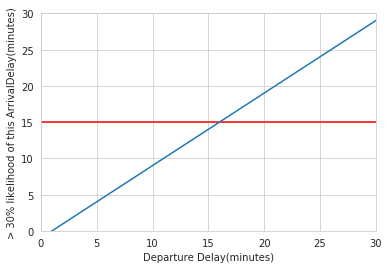

In [112]:
plt.axhline(y=15, color='r')
ax = plt.axes()

depdelay_train.plot(kind='line', x='DEP_DELAY', y='arrival_delay', ax=ax, ylim=(0,30), xlim=(0,30),legend=False)
ax.set_xlabel('Departure Delay(minutes)')
ax.set_ylabel('> 30% likelihood of this ArrivalDelay(minutes)')

Text(0, 0.5, '> 30% likelihood of this ArrivalDelay(minutes)')

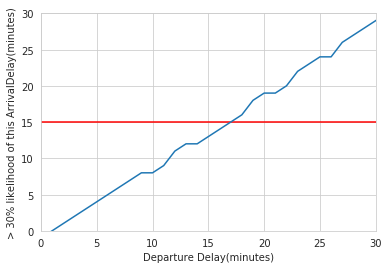

In [113]:
plt.axhline(y=15, color='r')
ax = plt.axes()

depdelay_test.plot(kind='line', x='DEP_DELAY', y='arrival_delay', ax=ax, ylim=(0,30), xlim=(0,30),legend=False)
ax.set_xlabel('Departure Delay(minutes)')
ax.set_ylabel('> 30% likelihood of this ArrivalDelay(minutes)')

6:4くらいになっている

In [114]:
depdelay_train.count()

DEP_DELAY        226
arrival_delay    226
numflights       226
dtype: int64

In [109]:
depdelay_test.count()

DEP_DELAY        161
arrival_delay    161
numflights       161
dtype: int64

#### 評価

In [128]:
# 外れ値を除去していない！
depdelayquery_eval = """
SELECT
  SUM(IF(DEP_DELAY < 16 AND ARR_DELAY < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16 AND ARR_DELAY >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16 AND ARR_DELAY >= 15, 1, 0)) AS correct_cancel,
  SUM(IF(DEP_DELAY >= 16 AND ARR_DELAY < 15, 1, 0)) AS wrong_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False'
)

"""
depdelay_eval = bq.Query(depdelayquery_eval).execute().result().to_dataframe()

In [129]:
depdelay_eval

,correct_nocancel,wrong_nocancel,correct_cancel,wrong_cancel
0,1389162,72486,236776,58359


In [131]:
print(depdelay_eval['correct_nocancel']/(depdelay_eval['correct_nocancel']+depdelay_eval['wrong_nocancel']))
print(depdelay_eval['correct_cancel']/(depdelay_eval['correct_cancel']+depdelay_eval['wrong_cancel']))

0    0.950408
dtype: float64
0    0.802263
dtype: float64


判断の境界線での評価

In [132]:
depdelayquery_eval_th = """
SELECT
  SUM(IF(DEP_DELAY = 15 AND ARR_DELAY < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15 AND ARR_DELAY >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16 AND ARR_DELAY >= 15, 1, 0)) AS correct_cancel,
  SUM(IF(DEP_DELAY = 16 AND ARR_DELAY < 15, 1, 0)) AS wrong_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False'
)

"""
depdelay_eval_th = bq.Query(depdelayquery_eval_th).execute().result().to_dataframe()

In [133]:
print(depdelay_eval_th['correct_nocancel']/(depdelay_eval_th['correct_nocancel']+depdelay_eval_th['wrong_nocancel']))
print(depdelay_eval_th['correct_cancel']/(depdelay_eval_th['correct_cancel']+depdelay_eval_th['wrong_cancel']))

0    0.727195
dtype: float64
0    0.299887
dtype: float64


-> 予想通り30%の確率で15分以上遅延する